# **Natural Language Processing Assignment**  
### **Classifying Bird Species Based on Descriptions Using Supervised Learning Techniques**

**Student Name**: Tia Isabel Solanki  
**Admin Number**: 220892L  
**Class**: AA2303

---

## **Part 1: Data Collection and Preprocessing**  
*Understanding the dataset and preparing the text for classification.*

---


###**Imports and Loading the Dataset**###

In [1]:
# Import Google Drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import Counter

# Text Processing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.util import bigrams
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define NLTK stopwords
nltk_stopwords = set(stopwords.words('english'))

# Domain-specific stopwords
domain_stopwords = {'species', 'bird', 'animal', 'description'}

# Combine NLTK stopwords with domain-specific stopwords
combined_stopwords = nltk_stopwords.union(domain_stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

In [4]:
# Load the dataset
# Update the path to your actual file location
df = pd.read_excel("/content/drive/MyDrive/NYP/Year 2/sem 2/[2] IT2391 NATURAL LANGUAGE PROCESSING/NLP Assignment/Data.xlsx")

###**Data  Exploration**
     Data exploration of the initial dataset


In [5]:
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,description,species
0,2 Jun 2023 ï¿½ The Javan myna shares some simi...,Javan Myna
1,Click here for more information about the Red ...,Collared Kingfisher
2,The black-headed oriole ( Oriolus larvatus) is...,Black-naped Oriole
3,"Search from thousands of royalty-free ""Javan M...",Javan Myna
4,521 foreground recordings and 156 background ...,Little Egret


In [6]:
print("Shape of the dataset:")
df.shape

Shape of the dataset:


(742, 2)

In [7]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
description    24
species         0
dtype: int64


In [8]:
# Drop rows with missing values
df.dropna(inplace=True)
print("Shape after removing missing values:", df.shape)

Shape after removing missing values: (718, 2)


In [9]:
# Find duplicates only in the 'description' column
description_duplicates = df[df['description'].duplicated(keep=False)]

# Print the number of duplicate rows
print(f"Number of duplicate rows in the 'description' column: {description_duplicates.shape[0]}")

# Display the duplicate rows
description_duplicates

Number of duplicate rows in the 'description' column: 167


,description,species
1,Click here for more information about the Red ...,Collared Kingfisher
15,The elegant little egret was once a rare visit...,Little Egret
17,26 Feb 2010 ï¿½ The Javan Mynas are everywhere...,Javan Myna
18,Project Noah is a tool that nature lovers can ...,Black-naped Oriole
25,"Published: August 24, 2020",Little Egret
...,...,...
724,The elegant little egret was once a rare visit...,Little Egret
729,"The Javan myna, also known as the white-vented...",Javan Myna
732,This is the real GONG JIAO WEI! How come the o...,Javan Myna
740,22 Oct 2023 ï¿½ Dragon Snake (Javan Tubercle S...,Javan Myna


In [10]:
# Drop the first occurrence of duplicate rows in the 'description' column, keeping the last occurrence
df = df.drop_duplicates(subset='description', keep='last')

In [11]:
# Check the result by displaying the updated dataframe
print(f"Updated DataFrame shape: {df.shape}")

Updated DataFrame shape: (606, 2)


In [12]:
print("\nData types of columns:")
print(df.dtypes)


Data types of columns:
description    object
species        object
dtype: object


In [13]:
# Analyze the distribution of species labels
print("\nDistribution of species labels:")
print(df['species'].value_counts())


Distribution of species labels:
species
Black-naped Oriole     192
Javan Myna             157
Collared Kingfisher    138
Little Egret           119
Name: count, dtype: int64


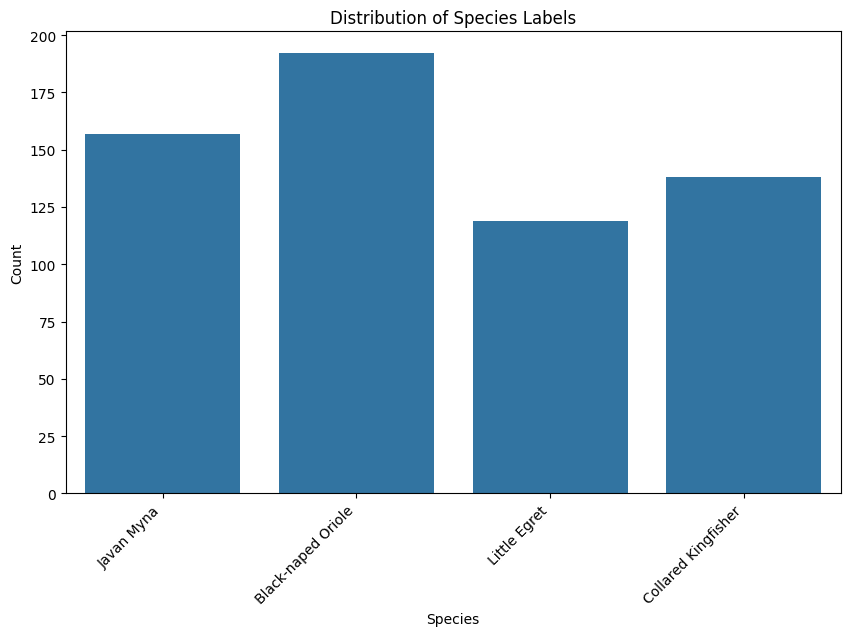

In [14]:
# Visualize the distribution of species labels
plt.figure(figsize=(10, 6))
sns.countplot(x='species', data=df)
plt.title('Distribution of Species Labels')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

The dataset is fairly well-balanced across the four species classes.

In [15]:
# Analyze text length
df['description_length'] = df['description'].apply(len)
print("\nDescriptive statistics of description length:")
print(df['description_length'].describe())


Descriptive statistics of description length:
count     606.000000
mean      242.721122
std       183.066821
min         8.000000
25%       156.000000
50%       194.000000
75%       328.000000
max      2430.000000
Name: description_length, dtype: float64


This code calculates the lengths of each description in the datset and stores it in a new column called "description_length". desribe() show that the descriptions vary alot from 8 to 2430 characters and has a median length of 179. We can see the level of detail in the description is not consistent which could affect the outcome of our classification model

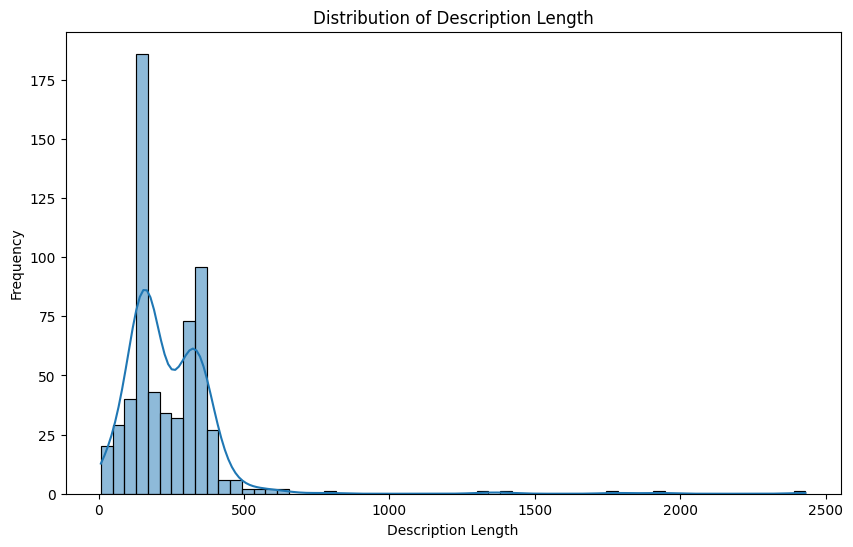

In [16]:
# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['description_length'], kde=True)
plt.title('Distribution of Description Length')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

The code creates a histogram to show the distribution of text length in the "description_length" column. It shows the overall shape of the distribution and we can see that most descriptions are quite short clustering below 500 characters while a few are much longer. This imbalance suggest that the data is right-skewed.

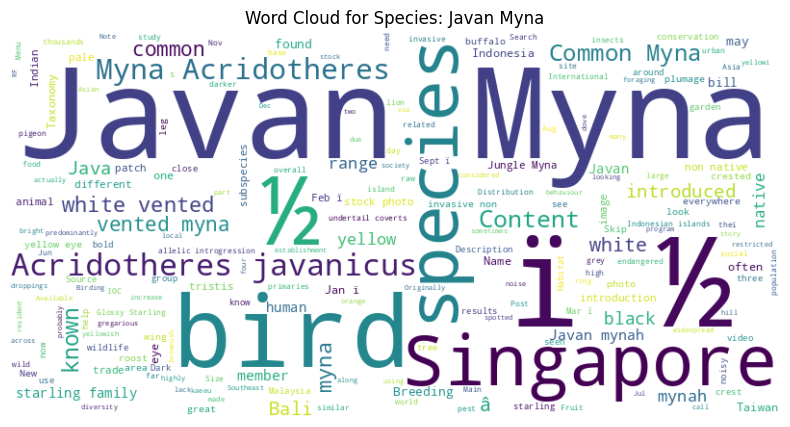

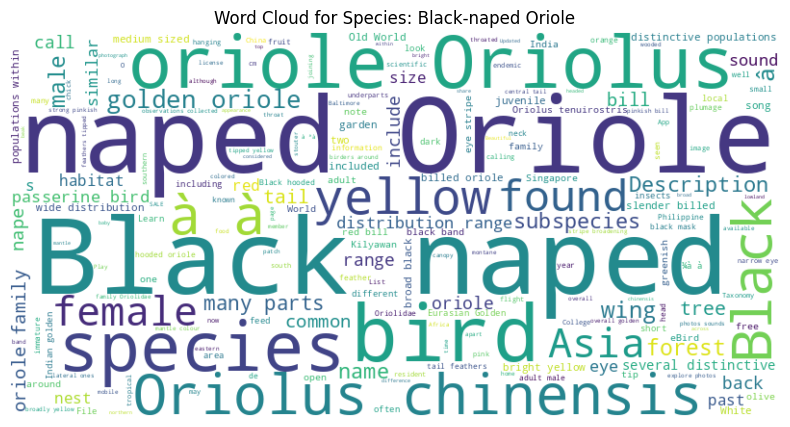

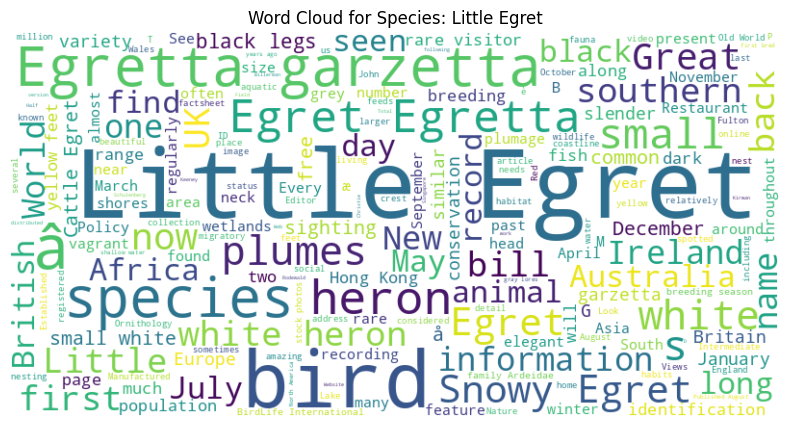

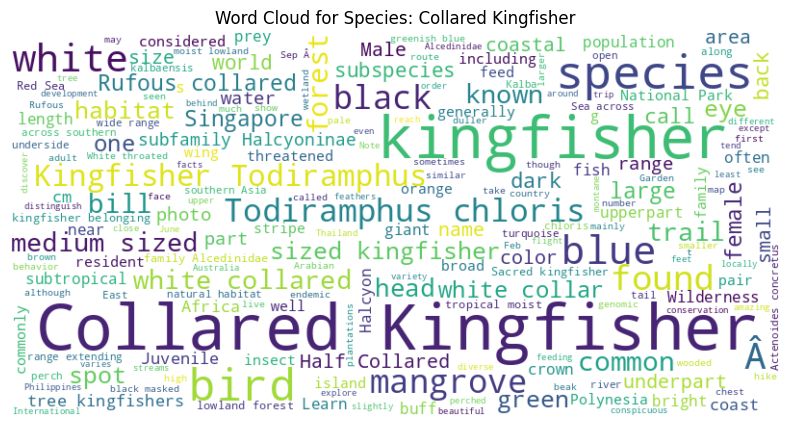

In [17]:
# Word Cloud Visualization for each species
for label in df['species'].unique():
    text = " ".join(df[df['species'] == label]['description'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Species: {label}")
    plt.show()

This code shows a word cloud for each of the 4 classes. We can see words like 'species' and 'bird', can be seen across all classes. These words are common across the categories should not be removed because they are relevant to the domain and provide important context for understanding the content of the descriptions. Additionally, there are unique words specific to each species that should not be removed, as they hold significance. On the other hand, terms like 'animal' should be removed, as they do not provide meaningful information. we can also see that each class is associated with certain countries.

<Axes: >

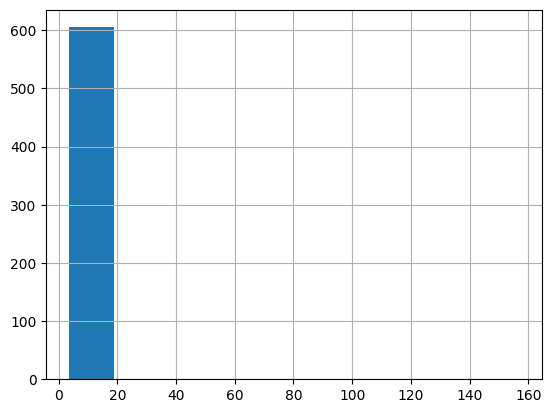

In [18]:
df['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

The histogram shows the distribution of these average word lengths, with most values between 0 and 20. This suggests that the descriptions generally consist of shorter words.

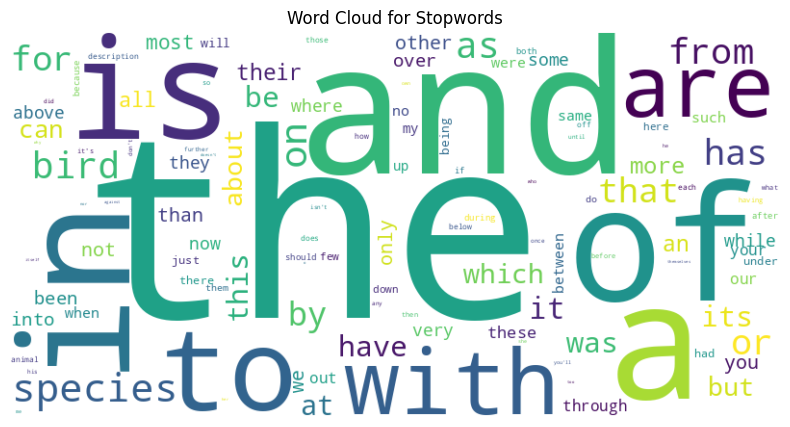

In [19]:

corpus = []
new = df['description'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in combined_stopwords:
        dic[word] += 1

# Create the word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dic)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Stopwords")
plt.show()

The word cloud shows the most common stopwords in the text data, which helps us to understand their frequency and dominance. This helps us identify and remove unnecessary noise, which improves the quality of text data. By cleaning the data of frequent stopwords such as that, the, and, is, of, a, and with, we can ensure that the model focuses on more meaningful terms, ultimately enhancing its ability to predict species accurately.

<Axes: >

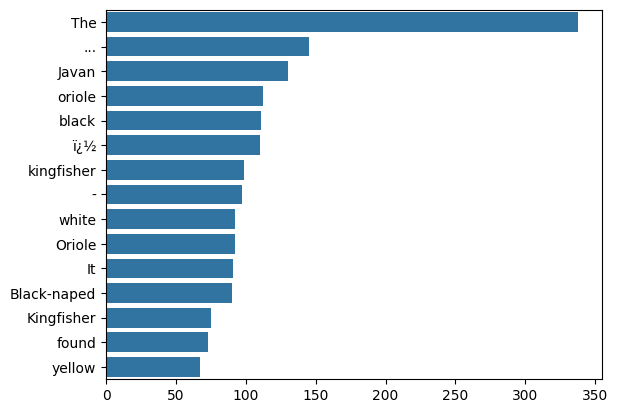

In [20]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in combined_stopwords):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

This horizontal bar chart shows the frequency of specific words in a text. The x-axis represents the frequency count, ranging from 0 to 350, and the y-axis lists the words. The word "The" has the highest frequency, followed by "..." and "Javan." This chart highlights the most common words, including some non-meaningful characters like "..." that should be removed to enhance text clarity and quality.

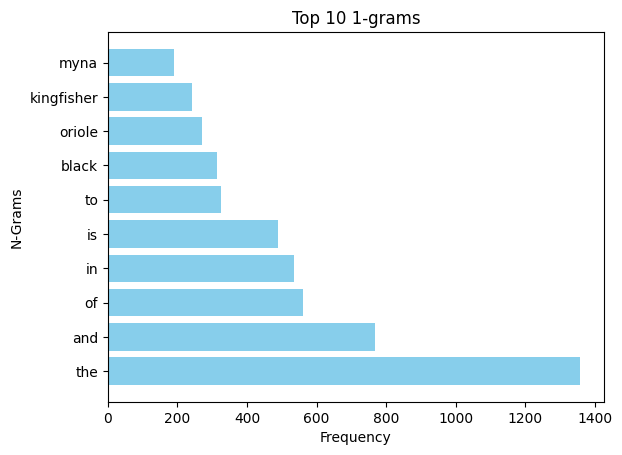

In [21]:
# Generate top unigrams and bigrams
def plot_top_ngrams(texts, n=1, top_n=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    x, y = zip(*words_freq)
    plt.barh(x, y, color='skyblue')
    plt.xlabel("Frequency")
    plt.ylabel("N-Grams")
    plt.title(f"Top {top_n} {n}-grams")
    plt.show()

if 'description' in df.columns:
    plot_top_ngrams(df['description'], n=1, top_n=10)  # Unigrams


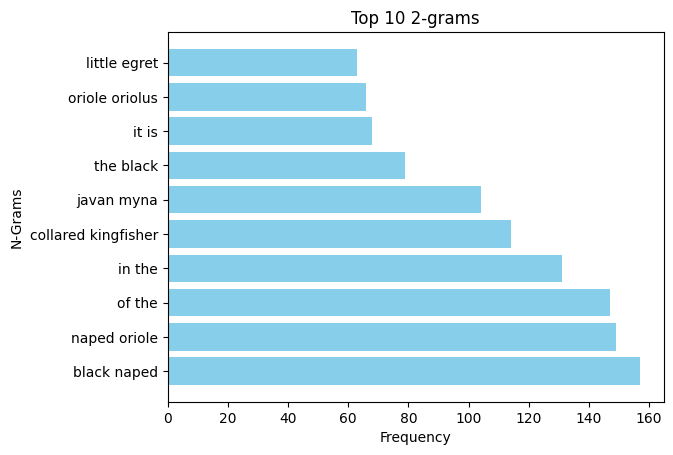

In [22]:
    plot_top_ngrams(df['description'], n=2, top_n=10)  # Bigrams

**Top 10 1-Grams:** This bar plot shows the most frequent unigrams, such as 'myna,' 'kingfisher,' and 'oriole,' which are species-related terms. These frequent words help the model identify key species mentioned in descriptions. However, some of these words may also include stop words that are not useful and need to be removed.

**Top 10 2-Grams:** The top bigrams, like 'little egret' and 'javan myna,' reveal common species combinations. This context helps the model understand species relationships and improves prediction accuracy by capturing more specific terms. Similar to the unigrams, some of these bigrams also may contain stop words, which we will remove. We will also use SpaCy later on to identify n-grams, ensuring that only relevant and meaningful combinations are kept.

### **Data Cleaning**

In [23]:
# Function to clean text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags (if any)
    text = re.sub(r'<[^>]+>', '', text)

    # Remove non-ASCII characters (but keep hyphens within words)
    text = re.sub(r'[^\x00-\x7F-]+', '', text)

    # Replace newlines, carriage returns, and tabs with a space
    text = re.sub(r'[\r\n\t]', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Remove standalone numbers but keep numbers in words (e.g., "version 2.0")
    text = re.sub(r'\b\d+\b(?!\.\d)', '', text)

    # Remove all punctuation except for hyphens within words
    text = re.sub(r'[!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~“”‘’]', '', text)

    # Remove any other special symbols like accented characters, etc.
    text = re.sub(r'[^\w\s-]', '', text)

    # Remove multiple spaces (including leading and trailing spaces)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove words containing numbers (e.g., "version2", "item10")
    text = re.sub(r'\b\w*\d\w*\b', '', text)

    # Remove rows starting with a month name (full or short form)
    text = re.sub(r'^(january|jan|february|feb|march|mar|april|apr|may|june|jun|july|jul|august|aug|september|sep|october|oct|november|nov|december|dec)\b[\s]*', '', text, flags=re.IGNORECASE)

    # Remove the word "article"
    text = re.sub(r'\barticle\b', '', text, flags=re.IGNORECASE)

    # Remove leading and trailing hyphens (if they appear at the start or end of the sentence)
    text = re.sub(r'^[\-]+', '', text)
    text = re.sub(r'[\-]+$', '', text)

    # Use spaCy to recognize compound words (hyphenated words)
    doc = nlp(text)
    cleaned_text = " ".join([token.text for token in doc])

    return cleaned_text

In [24]:
# Function to remove stopwords
def remove_stopwords(text):
    # Remove stopwords from the text and return the filtered text
    tokens = text.split()
    removed = [word for word in tokens if word.lower() in combined_stopwords]  # Track removed stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in combined_stopwords]
    return " ".join(filtered_tokens), removed  # Return both filtered text and removed stopwords

**Reasoning for removing identified stop words**
Since we’re doing text classification and not sentiment analysis, removing stop words is okay. In sentiment analysis, stop words can be useful because they may carry emotional tone or context (like "not," "good," or "bad"). However, for text classification, the focus is on the main content and category of the text, not on the sentiment. By removing stop words, we reduce unnecessary noise and help the model focus on the important keywords that are more relevant for classification, thus improving its performance

In [25]:
# Function to process tokens (tokenize, lemmatize, and generate bigrams)
def process_tokens(text):
    # Remove stopwords first
    text_no_stopwords, removed_stopwords = remove_stopwords(text)

    # Tokenize and lemmatize
    doc = nlp(text_no_stopwords)  # Tokenize and lemmatize

    # Tokenize and filter punctuations/spaces
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space]

    # Lemmatize tokens and remove punctuation and spaces
    cleaned_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

    # Generate bigrams
    bigrams_list = list(bigrams(cleaned_tokens))
    bigrams_str = [" ".join(bigram) for bigram in bigrams_list]

    return pd.Series([text_no_stopwords, tokens, bigrams_str, removed_stopwords])

**Reasoning for Using Lemmatization over Stemming**
I chose lemmatization over stemming because it better suits the task of predicting bird species from descriptions using TF-IDF. Lemmatization reduces words to their correct base form, preserving key terms like "flies" to "fly," while stemming would reduce it to "fli," which could alter the meaning. It also handles variations like "soaring," "soars," and "soared," normalizing them to "soar," which reduces vocabulary size and maintains consistency. In bird descriptions, terms like "plumage" or "migratory" and domain specific words, they could be oversimplified by stemming, while lemmatization keeps their intended meaning intact.

**Tokenization and Lemmatization with SpaCy**
The line doc = nlp(text_no_stopwords) runs the SpaCy pipeline, which first tokenizes the text (splitting it into words, punctuation, etc.) and then lemmatizes the tokens, converting them to their base forms. This reduces word variations and ensures consistency in the text, making it easier for analysis. The doc object contains both the original and lemmatized tokens along with additional information like part-of-speech tags.

In [26]:
# Apply cleaning to the 'description' column
if 'description' in df.columns:
    print("\nCleaning raw text data...\n")
    df['cleaned_description'] = df['description'].apply(clean_text)
    print("\nFirst few rows of cleaned text:")
df[['description', 'cleaned_description']].head()



Cleaning raw text data...


First few rows of cleaned text:


,description,cleaned_description
0,2 Jun 2023 ï¿½ The Javan myna shares some simi...,the javan myna shares some similarities with t...
2,The black-headed oriole ( Oriolus larvatus) is...,the black - headed oriole oriolus larvatus is ...
3,"Search from thousands of royalty-free ""Javan M...",search from thousands of royalty - free javan ...
4,521 foreground recordings and 156 background ...,foreground recordings and background recording...
5,The little egret (Egretta garzetta) is a smal...,the little egret egretta garzetta is a small w...


In [27]:
# Function to remove unwanted rows (e.g., rows that match a publication date pattern)
def remove_unwanted_rows(df):
    # Remove rows where 'description' matches the publication date pattern
    df = df[~df['cleaned_description'].str.contains(r'published: \w+ \d{1,2}, \d{4}', case=False, na=False)]
    return df

In [28]:
if 'description' in df.columns:
    # Remove unwanted rows based on the publication date pattern
    print("\nRemoving unwanted rows based on publication date pattern...\n")
    df = remove_unwanted_rows(df)
    print("\nShape after removing unwanted rows:", df.shape)


Removing unwanted rows based on publication date pattern...


Shape after removing unwanted rows: (606, 4)


In [29]:
    # Remove rows where the 'description' column is empty or contains only whitespace
    df = df[df['cleaned_description'].str.strip() != '']
    print("\nShape after removing empty descriptions:", df.shape)


Shape after removing empty descriptions: (604, 4)


In [30]:
    # Apply processing to remove stopwords, tokenize, and create bigrams
    print("\nProcessing text to remove stopwords, tokenize, and generate bigrams...\n")
    df[['cleaned_no_stopwords', 'tokens', 'bigrams', 'removed_stopwords']] = df['cleaned_description'].apply(process_tokens)


Processing text to remove stopwords, tokenize, and generate bigrams...



In [31]:
    # Print sample of cleaned text (no stopwords), tokens, bigrams, and removed stopwords
    print("\nSample cleaned text (no stopwords), tokens, bigrams, and removed stopwords:")
    df[['cleaned_description', 'cleaned_no_stopwords', 'tokens', 'bigrams', 'removed_stopwords']].head()



Sample cleaned text (no stopwords), tokens, bigrams, and removed stopwords:


,cleaned_description,cleaned_no_stopwords,tokens,bigrams,removed_stopwords
0,the javan myna shares some similarities with t...,javan myna shares similarities common myna ter...,"[javan, myna, shares, similarities, common, my...","[javan myna, myna share, share similaritie, si...","[the, some, with, the, in, of, it, can, be, by..."
2,the black - headed oriole oriolus larvatus is ...,black - headed oriole oriolus larvatus family ...,"[black, headed, oriole, oriolus, larvatus, fam...","[black head, head oriole, oriole oriolus, orio...","[the, is, a, species, of, bird, in, the, it, i..."
3,search from thousands of royalty - free javan ...,search thousands royalty - free javan myna sto...,"[search, thousands, royalty, free, javan, myna...","[search thousand, thousand royalty, royalty fr...","[from, of, and, for, your, and, more, on]"
4,foreground recordings and background recording...,foreground recordings background recordings eg...,"[foreground, recordings, background, recording...","[foreground recording, recording background, b...","[and, of]"
5,the little egret egretta garzetta is a small w...,little egret egretta garzetta small white hero...,"[little, egret, egretta, garzetta, small, whit...","[little egret, egret egretta, egretta garzetta...","[the, is, a, to, the, the, is, in, and]"


In [32]:
    # Extract all removed stopwords from the dataframe
    all_removed_stopwords = [item for sublist in df['removed_stopwords'] for item in sublist]
    removed_stopwords_set = set(all_removed_stopwords)  # Get unique stopwords


In [33]:
    # Print the removed stopwords
    print("\nList of unique stopwords removed:")
    print(removed_stopwords_set)


List of unique stopwords removed:
{'her', 'such', 'their', 'at', 'down', 'd', 'both', 'nor', 's', 'm', 'y', 'no', 'can', 'and', 'into', 'on', 'same', 'off', 're', 'until', 'description', 'again', 'but', 'this', 'been', 'for', 'so', 'those', 'the', 'when', 'who', 'have', 've', 'my', 'if', 'than', 'because', 'him', 'does', 'these', 'its', 'species', 'against', 'through', 'is', 'then', 'once', 'between', 'about', 'an', 'why', 'having', 'animal', 'as', 'by', 'up', 'they', 'of', 'did', 'there', 'where', 'other', 'each', 'was', 'has', 'own', 'above', 'me', 'you', 'them', 'we', 'should', 'under', 'be', 'which', 'too', 'in', 'below', 'most', 'only', 'out', 'o', 't', 'or', 'before', 'few', 'very', 'had', 'more', 'just', 'bird', 'while', 'he', 'll', 'to', 'were', 'now', 'what', 'how', 'i', 'all', 'over', 'being', 'any', 'are', 'not', 'here', 'with', 'she', 'it', 'his', 'after', 'will', 'further', 'your', 'themselves', 'from', 'some', 'itself', 'our', 'do', 'during', 'that', 'a'}


In [34]:
df


,description,species,description_length,cleaned_description,cleaned_no_stopwords,tokens,bigrams,removed_stopwords
0,2 Jun 2023 ï¿½ The Javan myna shares some simi...,Javan Myna,162,the javan myna shares some similarities with t...,javan myna shares similarities common myna ter...,"[javan, myna, shares, similarities, common, my...","[javan myna, myna share, share similaritie, si...","[the, some, with, the, in, of, it, can, be, by..."
2,The black-headed oriole ( Oriolus larvatus) is...,Black-naped Oriole,349,the black - headed oriole oriolus larvatus is ...,black - headed oriole oriolus larvatus family ...,"[black, headed, oriole, oriolus, larvatus, fam...","[black head, head oriole, oriole oriolus, orio...","[the, is, a, species, of, bird, in, the, it, i..."
3,"Search from thousands of royalty-free ""Javan M...",Javan Myna,177,search from thousands of royalty - free javan ...,search thousands royalty - free javan myna sto...,"[search, thousands, royalty, free, javan, myna...","[search thousand, thousand royalty, royalty fr...","[from, of, and, for, your, and, more, on]"
4,521 foreground recordings and 156 background ...,Little Egret,112,foreground recordings and background recording...,foreground recordings background recordings eg...,"[foreground, recordings, background, recording...","[foreground recording, recording background, b...","[and, of]"
5,The little egret (Egretta garzetta) is a smal...,Little Egret,185,the little egret egretta garzetta is a small w...,little egret egretta garzetta small white hero...,"[little, egret, egretta, garzetta, small, whit...","[little egret, egret egretta, egretta garzetta...","[the, is, a, to, the, the, is, in, and]"
...,...,...,...,...,...,...,...,...
737,"August 13, 2016 - HISTORICAL records show that...",Little Egret,148,historical records show that the little egre...,historical records show little egret egretta g...,"[historical, records, show, little, egret, egr...","[historical record, record show, show little, ...","[that, the, was, once, and, very, in, and]"
738,File: Black-naped Oriole (Oriolus chinensis ch...,Black-naped Oriole,101,file black - naped oriole oriolus chinensis ch...,file black - naped oriole oriolus chinensis ch...,"[file, black, naped, oriole, oriolus, chinensi...","[file black, black naped, naped oriole, oriole...",[]
739,Larger than a Cattle Egret and with black leg...,Little Egret,159,larger than a cattle egret and with black legs...,larger cattle egret black legs yellow slippers...,"[larger, cattle, egret, black, legs, yellow, s...","[large cattle, cattle egret, egret black, blac...","[than, a, and, with, and, a, are, in, or, very..."
740,22 Oct 2023 ï¿½ Dragon Snake (Javan Tubercle S...,Javan Myna,178,dragon snake javan tubercle snake javan mudsna...,dragon snake javan tubercle snake javan mudsna...,"[dragon, snake, javan, tubercle, snake, javan,...","[dragon snake, snake javan, javan tubercle, tu...","[bird, that, with]"


### **Saving Cleaned Data CSV File**###

In [35]:
# Specify the path to save the CSV file in your Google Drive, including the file name
file_path = '/content/drive/MyDrive/NYP/Year 2/sem 2/[2] IT2391 NATURAL LANGUAGE PROCESSING/NLP Assignment/cleaned_text_output.csv'

# Save 'description' and 'cleaned_no_stopwords' columns to the CSV file
df[['description', 'cleaned_no_stopwords', 'species']].to_csv(file_path, index=False)

# Confirm that the CSV file is saved correctly by loading and printing its contents
print("\nSaved CSV content preview:")
pd.read_csv(file_path).head()


Saved CSV content preview:


,description,cleaned_no_stopwords,species
0,2 Jun 2023 ï¿½ The Javan myna shares some simi...,javan myna shares similarities common myna ter...,Javan Myna
1,The black-headed oriole ( Oriolus larvatus) is...,black - headed oriole oriolus larvatus family ...,Black-naped Oriole
2,"Search from thousands of royalty-free ""Javan M...",search thousands royalty - free javan myna sto...,Javan Myna
3,521 foreground recordings and 156 background ...,foreground recordings background recordings eg...,Little Egret
4,The little egret (Egretta garzetta) is a smal...,little egret egretta garzetta small white hero...,Little Egret


### **Final Data Understanding**

In [36]:
df.describe()

,description_length
count,604.000000
mean,243.251656
std,183.086816
min,10.000000
25%,156.000000
50%,196.000000
75%,328.250000
max,2430.000000


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 604 entries, 0 to 741
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   description           604 non-null    object
 1   species               604 non-null    object
 2   description_length    604 non-null    int64 
 3   cleaned_description   604 non-null    object
 4   cleaned_no_stopwords  604 non-null    object
 5   tokens                604 non-null    object
 6   bigrams               604 non-null    object
 7   removed_stopwords     604 non-null    object
dtypes: int64(1), object(7)
memory usage: 42.5+ KB


In [38]:
df.shape

(604, 8)

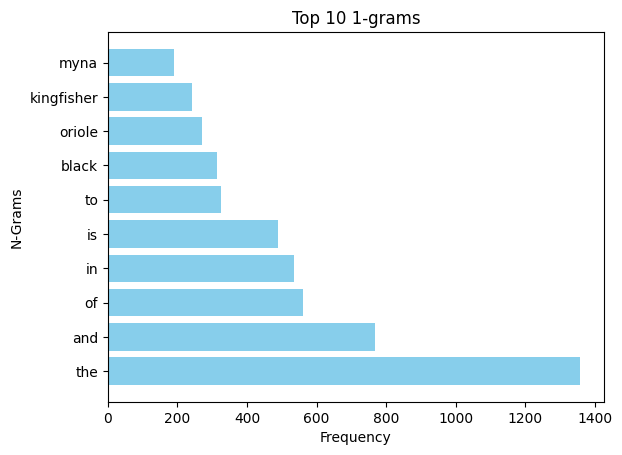

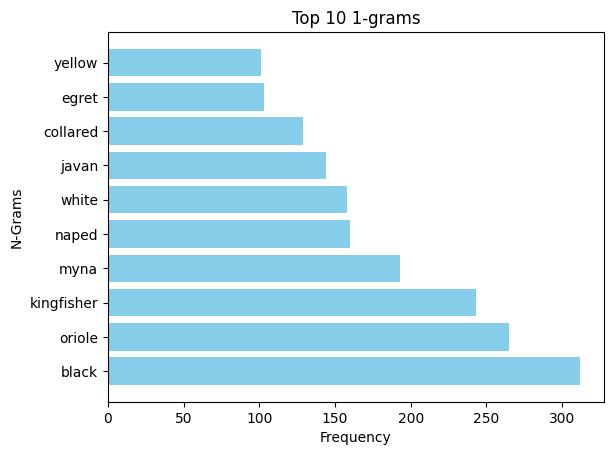

In [39]:
# Function to plot top n-grams
def plot_top_ngrams(texts, n=1, top_n=10):
    from sklearn.feature_extraction.text import CountVectorizer
    vec = CountVectorizer(ngram_range=(n, n)).fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    x, y = zip(*words_freq)
    plt.barh(x, y, color='skyblue')
    plt.xlabel("Frequency")
    plt.ylabel("N-Grams")
    plt.title(f"Top {top_n} {n}-grams")
    plt.show()

# Plot top unigrams before and after preprocessing
plot_top_ngrams(df['description'], n=1, top_n=10)  # Original unigrams
plot_top_ngrams(df['cleaned_no_stopwords'], n=1, top_n=10)  # Preprocessed unigrams


This visual compares the top 10 words **before** and **after** data cleaning. We can see the removal of stopwords, making the it cleaner and more meaningful set of words in the processed text.

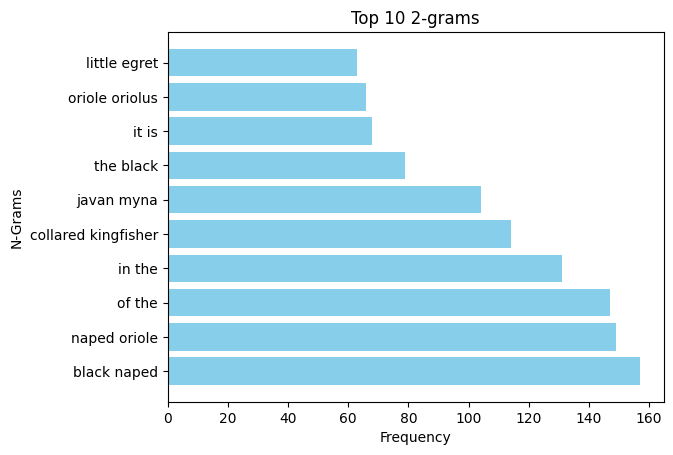

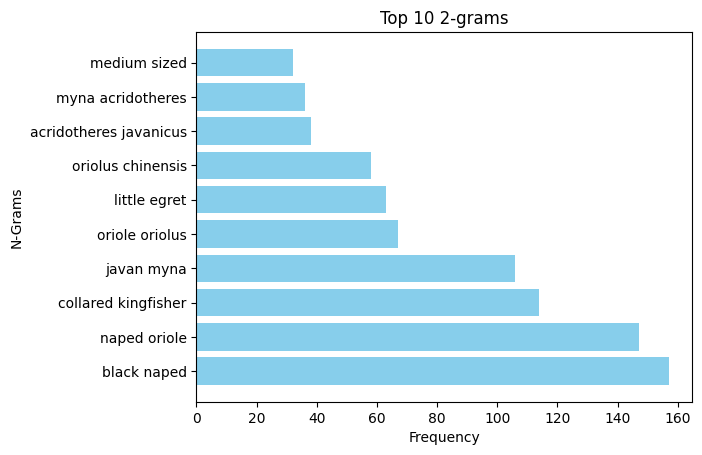

In [40]:
# Plot top unigrams before and after preprocessing
plot_top_ngrams(df['description'], n=2, top_n=10)  # Original unigrams
plot_top_ngrams(df['cleaned_no_stopwords'], n=2, top_n=10)  # Preprocessed unigrams


This visual displays the top 10 bigrams **before** and **after** data cleaning. The cleaned bigrams are more coherent and meaningful, which can improve our models performance


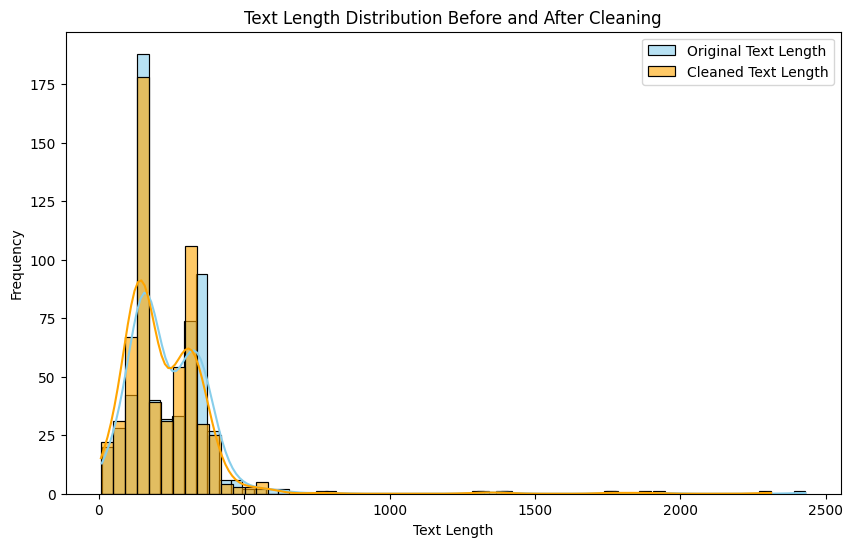

In [41]:
# Assuming you have columns like 'description' for original text and 'cleaned_description' for the cleaned text.
df['original_length'] = df['description'].apply(len)
df['cleaned_length'] = df['cleaned_description'].apply(len)

# Compare the text length distributions before and after preprocessing
plt.figure(figsize=(10, 6))
sns.histplot(df['original_length'], kde=True, color='skyblue', label='Original Text Length', alpha=0.6)
sns.histplot(df['cleaned_length'], kde=True, color='orange', label='Cleaned Text Length', alpha=0.6)
plt.title('Text Length Distribution Before and After Cleaning')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


This histogram shows a comparative analysis of text lengths before and after the cleaning process. The blue bars show the original text lengths, while the orange bars show the cleaned text lengths. The cleaning process has significantly shortened the texts, with a alot of the lengths around smaller values. This shows we have effectively removed unnecessary or irrelevant content, resulting in more concise texts.

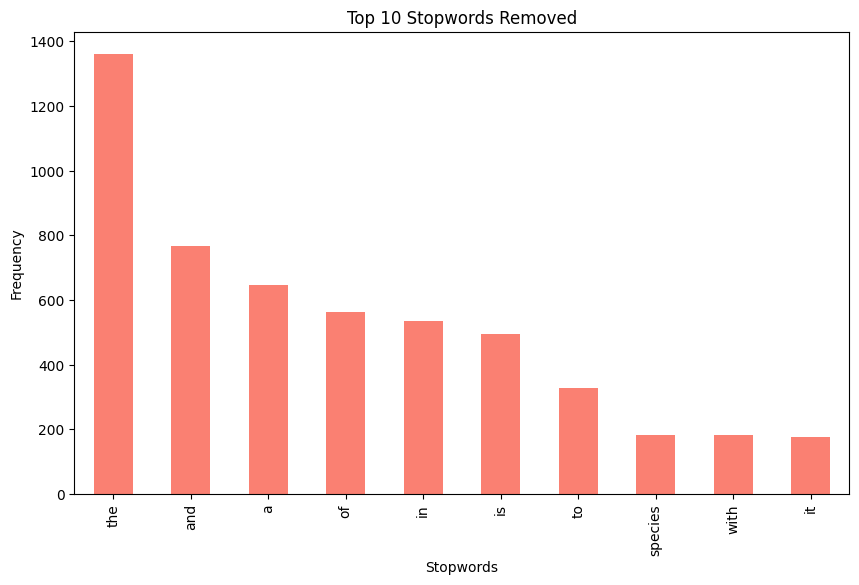

In [42]:
# Extract and display removed stopwords
all_removed_stopwords = [item for sublist in df['removed_stopwords'] for item in sublist]
removed_stopwords_set = set(all_removed_stopwords)  # Get unique stopwords
removed_stopwords_freq = pd.Series(all_removed_stopwords).value_counts().head(10)

plt.figure(figsize=(10, 6))
removed_stopwords_freq.plot(kind='bar', color='salmon')
plt.title('Top 10 Stopwords Removed')
plt.xlabel('Stopwords')
plt.ylabel('Frequency')
plt.show()


This bar chart, "Top 10 Stopwords Removed," shows the frequency of the most common stopwords eliminated. The x-axis lists the stopwords, and the y-axis indicates their frequency. The words "the," "and," "a," "of," "in," "is," "to," "species," "with," and "it" are displayed, with "the" being the most frequent.

In [43]:
# Sample raw and cleaned text comparison
sample = df[['description', 'cleaned_description']].head(5)
print(sample)

                                         description  \
0  2 Jun 2023 ï¿½ The Javan myna shares some simi...   
2  The black-headed oriole ( Oriolus larvatus) is...   
3  Search from thousands of royalty-free "Javan M...   
4   521 foreground recordings and 156 background ...   
5   The little egret (Egretta garzetta) is a smal...   

                                 cleaned_description  
0  the javan myna shares some similarities with t...  
2  the black - headed oriole oriolus larvatus is ...  
3  search from thousands of royalty - free javan ...  
4  foreground recordings and background recording...  
5  the little egret egretta garzetta is a small w...  


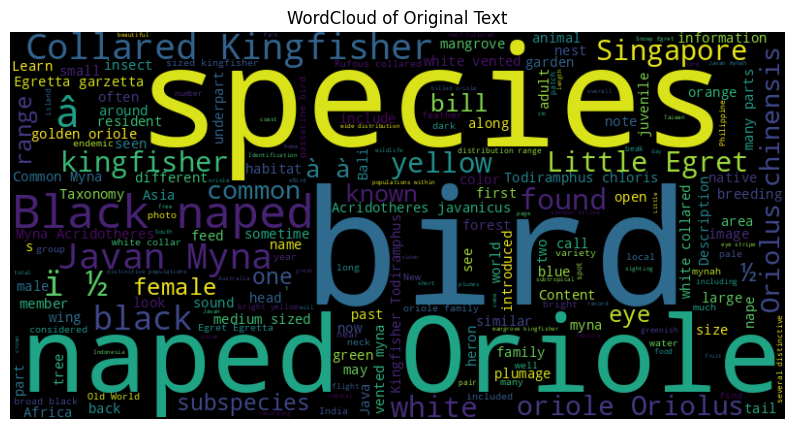

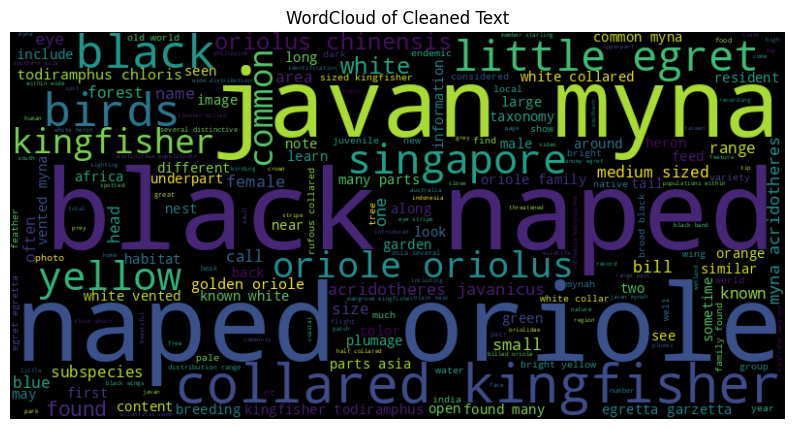

In [44]:
from wordcloud import WordCloud

# Generate word cloud for original text
wordcloud = WordCloud(width=800, height=400).generate(" ".join(df['description']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of Original Text')
plt.axis('off')
plt.show()

# Generate word cloud for cleaned text
wordcloud = WordCloud(width=800, height=400).generate(" ".join(df['cleaned_no_stopwords']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of Cleaned Text')
plt.axis('off')
plt.show()


The two word clouds compare the frequency of words in the original and cleaned texts. The top word cloud, labeled "WordCloud of Original Text," shows the most common words in larger fonts, while the bottom word cloud, labeled "WordCloud of Cleaned Text," highlights how the cleaning process affects word prominence and frequency. Both clouds feature words like "bird," "species," "black," "naped," "oriole," "kingfisher," and "javan myna," showing that the text cleaning process can help focus the text on more relevant content.

In [45]:
# Ensure original_tokens_count is calculated by tokenizing the description
df['original_tokens_count'] = df['description'].apply(lambda x: len(str(x).split()))
df['cleaned_length'] = df['cleaned_no_stopwords'].apply(lambda x: len(str(x)))
df['cleaned_tokens_count'] = df['cleaned_no_stopwords'].apply(lambda x: len(str(x).split()))

# Create a summary of changes
df['original_length'] = df['description'].apply(lambda x: len(str(x)))
summary = pd.DataFrame({
    'Before Preprocessing': [df['original_length'].mean(), df['original_tokens_count'].mean()],
    'After Preprocessing': [df['cleaned_length'].mean(), df['cleaned_tokens_count'].mean()]
}, index=['Average Text Length', 'Average Tokens Count'])

print(summary)


                      Before Preprocessing  After Preprocessing
Average Text Length             243.251656           171.001656
Average Tokens Count             38.839404            24.056291


This image compares text statistics before and after preprocessing. Specifically, it displays the average text length and average token count. Before preprocessing, the average text length is 242.92 characters, and the average token count is 38.78. After preprocessing, the average text length decreases to 170.68 characters, and the average token count drops to 23.99. This shows that preprocessing significantly reduces both the length and complexity of the texts.



In [46]:
df[['removed_stopwords', 'original_length', 'cleaned_length', 'original_tokens_count', 'cleaned_tokens_count']].head()


,removed_stopwords,original_length,cleaned_length,original_tokens_count,cleaned_tokens_count
0,"[the, some, with, the, in, of, it, can, be, by...",162,98,27,12
2,"[the, is, a, species, of, bird, in, the, it, i...",349,242,55,32
3,"[from, of, and, for, your, and, more, on]",177,142,27,23
4,"[and, of]",112,85,15,9
5,"[the, is, a, to, the, the, is, in, and]",185,147,28,19


The columns represent different aspects of text data before and after preprocessing.

- removed_stopwords contains the text with stopwords removed.
- original_length is the character count of the original text
- cleaned_length is the character count after preprocessing steps like stopword removal.
- original_tokens_count shows the number of tokens (words) in the original text
- cleaned_tokens_count shows the token count after removing stopwords and other unnecessary elements.